In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The codes are taken from
[Digital sreeni ](https://www.youtube.com/watch?v=hTpq9lzAb8M&t=1365s) and [Idiot developer ](https://www.youtube.com/watch?v=LkmgdNpcgTM&t=841s) then few changes are made for this project.


**Building The Model**

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in autoencoder and U-Net
def convolution_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = convolution_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = convolution_block(x, num_filters)
    return x

#Encoder will be the same for Autoencoder and U-net
#We are getting both conv output and maxpool output for convenience.
#we will ignore conv output for Autoencoder. It acts as skip connections for U-Net
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    encoded = convolution_block(p4, 1024) #Bridge
    
    return encoded

#Decoder for Autoencoder ONLY. 
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

#Use encoder and decoder blocks to build the autoencoder. 
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)


#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = convolution_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = convolution_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    #print(model.summary())
    return model

# model1=build_unet((512, 512, 3))
# model2=build_autoencoder((512, 512, 3))
# print(model1.summary())




Loading the data

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import os
from keras.models import Model
from matplotlib import pyplot as plt
SIZE=256


from tqdm import tqdm
img_data=[]
path1 = '/content/drive/MyDrive/Colab Notebooks/Skull images'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))

100%|██████████| 157/157 [00:00<00:00, 201.24it/s]


In [ ]:
print(len(img_data))

157


In [ ]:
img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.

Calling autoencoder model

In [ ]:
autoencoder_model=build_autoencoder(img.shape)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(autoencoder_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_38 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_36 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 256, 256, 64)      0         
                                                                 
 conv2d_39 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_37 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                          

Training the model

In [ ]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


create_dir("files")   
csv_path = os.path.join("files", "encoder_data.csv")     
callbacks = [
         
        CSVLogger(csv_path)
    ]

history = autoencoder_model.fit(img_array , img_array ,
        epochs=100, verbose=1,callbacks=callbacks)


autoencoder_model.save('autoencoder_for_skull_images.h5') 

Epoch 1/100
5/5 [==============================] - 10s 2s/step - loss: 0.1153 - accuracy: 0.3367
Epoch 2/100
5/5 [==============================] - 8s 2s/step - loss: 0.0521 - accuracy: 0.4077
Epoch 3/100
5/5 [==============================] - 8s 2s/step - loss: 0.0463 - accuracy: 0.4743
Epoch 4/100
5/5 [==============================] - 8s 2s/step - loss: 0.0433 - accuracy: 0.5075
Epoch 5/100
5/5 [==============================] - 8s 2s/step - loss: 0.0386 - accuracy: 0.4701
Epoch 6/100
5/5 [==============================] - 8s 2s/step - loss: 0.0334 - accuracy: 0.5926
Epoch 7/100
5/5 [==============================] - 8s 2s/step - loss: 0.0278 - accuracy: 0.5803
Epoch 8/100
5/5 [==============================] - 8s 2s/step - loss: 0.0228 - accuracy: 0.4892
Epoch 9/100
5/5 [==============================] - 8s 2s/step - loss: 0.0200 - accuracy: 0.3135
Epoch 10/100
5/5 [==============================] - 8s 2s/step - loss: 0.0184 - accuracy: 0.1961
Epoch 11/100
5/5 [====================

Checking the model

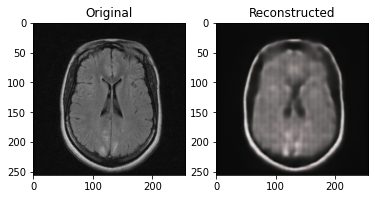

In [ ]:
from keras.models import load_model
autoencoder_model = load_model("autoencoder_for_skull_images.h5", compile=False)
       
import random
num=random.randint(0, len(img_array)-1)
test_img = np.expand_dims(img_array[num], axis=0)
pred = autoencoder_model.predict(test_img)

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()


Getting just the encoder part

In [ ]:
input_shape = (256, 256, 3)
input_img = Input(shape=input_shape)

encoder = build_encoder(input_img)
encoder_model = Model(input_img, encoder)
print(encoder_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_57 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_54 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 activation_54 (Activation)  (None, 256, 256, 64)      0         
                                                                 
 conv2d_58 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_55 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                          

Saving the encoder weights

In [ ]:
num_encoder_layers = len(encoder_model.layers) #35 layers in our encoder. 

#Get weights for the 35 layers from trained autoencoder model and assign to our new encoder model 
for l1, l2 in zip(encoder_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())

#Verify if the weights are the same between autoencoder and encoder only models. 
autoencoder_weights = autoencoder_model.get_weights()[0][1]
encoder_weights = encoder_model.get_weights()[0][1]

#Save encoder weights for future comparison
np.save('pretrained_encoder-weights.npy', encoder_weights )

Saving the pretrained model for unet

In [ ]:
#Now let us define a Unet with same encoder part as out autoencoder. 
#Then load weights from the original autoencoder for the first 35 layers (encoder)
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)

#Print layer names for each model to verify the layers....
#First 35 layers should be the same in both models. 
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

autoencoder_layer_names = []
for layer in autoencoder_model.layers:
    autoencoder_layer_names.append(layer.name)
    
#Make sure the first 35 layers are the same. Remember that the exct names of the layers will be different.
###########

#Set weights to encoder part of the U-net (first 35 layers)
for l1, l2 in zip(unet_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_64 (BatchN  (None, 256, 256, 64  256        ['conv2d_67[0][0]']              
 ormalization)                  )                                                             

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.7 MB/s 


In [ ]:
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
unet_model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()
print(unet_model.output_shape)

unet_model.save('unet_model_weights.h5')

Segmentation Models: using `keras` framework.
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_64 (BatchN  (None, 256, 256, 64  256        ['conv2d_67[0][0]']              
 ormalization)                  )               

Declaring the metrics functions

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

The functions needed for training unet

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
 

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path,"Images", "*.png")))
    masks = sorted(glob(os.path.join(path,"Masks", "*.png")))
   

    split_size = int(len(images) * split)          # we are calculating the split size here

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)  # training data and validation data will be selected randomly and the randomness seed is 42
    train_y , valid_y  = train_test_split(masks, test_size=split_size, random_state=42)
    

     

    return (train_x, train_y), (valid_x, valid_y) 

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x= cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x,y):
    def _parse(x,y):
        x = x.decode()
        y = y.decode()
       

        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset


Train UNET for the data without pre processing

In [ ]:

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size =4
    lr = 1e-5
    num_epochs = 50
    model_path = os.path.join("files", "Unet_model_skull.h5")
    csv_path = os.path.join("files", "Skull_data.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/Skull data"
    (train_x, train_y), (valid_x, valid_y)  = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
   

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    #model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy"])
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 120 - 120
Valid: 30 - 30
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.7440 - dice_coef: 0.2583 - iou: 0.1489 - recall_1: 0.6585 - precision_1: 0.2435
Epoch 1: val_loss improved from inf to 0.81148, saving model to files/Unet_model_skull.h5
30/30 [==============================] - 14s 394ms/step - loss: 0.7417 - accuracy: 0.7440 - dice_coef: 0.2583 - iou: 0.1489 - recall_1: 0.6585 - precision_1: 0.2435 - val_loss: 0.8115 - val_accuracy: 0.8827 - val_dice_coef: 0.1891 - val_iou: 0.1045 - val_recall_1: 7.2797e-04 - val_precision_1: 0.8750 - lr: 1.0000e-05
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.8093 - dice_coef: 0.3336 - iou: 0.2008 - recall_1: 0.8226 - precision_1: 0.3395
Epoch 2: val_loss did not improve from 0.81148
30/30 [==============================] - 9s 282ms/step - loss: 0.6664 - accuracy: 0.8093 - dice_coef: 0.3336 - iou: 0.2008 - recall_1: 0.8226 - precision_1: 0.3395 - val_loss

Output for The unet model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
 
if __name__ == "__main__":
 
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/Unet_model_skull.h5")

    """ Dataset """
    path = "/content/drive/MyDrive/Colab Notebooks/Test skull"
    test_img=sorted(glob(os.path.join(path,"img" ,"*.png")))
    ground_truth=sorted(glob(os.path.join(path,"mask" ,"*.png")))

    """ Predicting the mask """
    for x, y  in tqdm(zip(test_img,ground_truth), total=len(test_img)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        img = cv2.imread(x, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        img_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.resize(img_y, (W, H))
        img_y = np.expand_dims(img_y, axis=-1)  ## (512, 512, 1)
        img_y = np.concatenate([img_y, img_y, img_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"/content/drive/MyDrive/Colab Notebooks/Results/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((H, 10, 3)) * 255

        output_image = np.concatenate([img, sep_line, img_y, sep_line, y_pred*255], axis=1)
        #cat_image = np.concatenate([sep_line,y_pred*255,sep_line], axis=1) # this line for just the output segment
        #cat_image = np.concatenate([ori_x,sep_line,y_pred*255], axis=1) # this line for just the output segment and the test image
        cv2.imwrite(save_image_path, output_image)

100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Now lets load the pretrained weights

In [ ]:
 
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm

input_shape = (256, 256, 3)

Segmentation Models: using `keras` framework.


In [ ]:
pre_trained_unet_model = build_unet(input_shape)
pre_trained_unet_model.load_weights('unet_model_weights.h5')
pre_trained_unet_model_weights = pre_trained_unet_model.get_weights()[0][1]

In [ ]:
pretrained_encoder_wts = np.load('pretrained_encoder-weights.npy')

if pre_trained_unet_model_weights.all() == pretrained_encoder_wts.all():
    print("Both weights are identical")
else: 
    print("Something wrong, weghts are different")

Both weights are identical


Now train the Unet model with the preprocessed weight

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size =4
    lr = 1e-5
    num_epochs = 50
    model_path = os.path.join("files", "Unet_model_skull_pretrained.h5")
    csv_path = os.path.join("files", "Skull_data_pretrained.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/Skull data"
    (train_x, train_y), (valid_x, valid_y)  = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
   

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    #model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy"])
    pre_trained_unet_model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])
    #pre_trained_unet_model.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score ,metrics])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)
    ]

    pre_trained_unet_model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 120 - 120
Valid: 30 - 30
Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.5457 - dice_coef: 0.2449 - iou: 0.1400 - recall_4: 0.8726 - precision_4: 0.1752
Epoch 1: val_loss improved from inf to 0.79184, saving model to files/Unet_model_skull_pretrained.h5
30/30 [==============================] - 14s 351ms/step - loss: 0.7551 - accuracy: 0.5457 - dice_coef: 0.2449 - iou: 0.1400 - recall_4: 0.8726 - precision_4: 0.1752 - val_loss: 0.7918 - val_accuracy: 0.5954 - val_dice_coef: 0.2086 - val_iou: 0.1166 - val_recall_4: 0.8378 - val_precision_4: 0.2032 - lr: 1.0000e-05
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.7436 - dice_coef: 0.3199 - iou: 0.1908 - recall_4: 0.9638 - precision_4: 0.2905
Epoch 2: val_loss improved from 0.79184 to 0.76687, saving model to files/Unet_model_skull_pretrained.h5
30/30 [==============================] - 10s 334ms/step - loss: 0.6801 - accuracy: 0.7436 - dice_coef: 0.3199

Output for the trained model

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
 
if __name__ == "__main__":
 
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/Unet_model_skull_pretrained.h5")

    """ Dataset """
    path = "/content/drive/MyDrive/Colab Notebooks/Test skull"
    test_img=sorted(glob(os.path.join(path,"img" ,"*.png")))
    ground_truth=sorted(glob(os.path.join(path,"mask" ,"*.png")))

    """ Predicting the mask """
    for x, y  in tqdm(zip(test_img,ground_truth), total=len(test_img)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        img = cv2.imread(x, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        img_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.resize(img_y, (W, H))
        img_y = np.expand_dims(img_y, axis=-1)  ## (512, 512, 1)
        img_y = np.concatenate([img_y, img_y, img_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"/content/drive/MyDrive/Colab Notebooks/Results/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((H, 10, 3)) * 255

        output_image = np.concatenate([img, sep_line, img_y, sep_line, y_pred*255], axis=1)
        #cat_image = np.concatenate([sep_line,y_pred*255,sep_line], axis=1) # this line for just the output segment
        #cat_image = np.concatenate([ori_x,sep_line,y_pred*255], axis=1) # this line for just the output segment and the test image
        cv2.imwrite(save_image_path, output_image)

100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Comparing the worst outputs

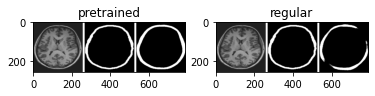

In [ ]:
x=cv2.imread("With.png")
x=im_rgb = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
y=cv2.imread("Without.png")
y=im_rgb = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(x)
plt.title('pretrained')
plt.subplot(1,2,2)
plt.imshow(y)
plt.title('regular')
plt.show()


Comparing the IOU and EFFICIENCY graph

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
x=pd.read_csv("Skull_data.csv")
y=pd.read_csv("Skull_data_pretrained.csv")

In [ ]:
regular_iou=x.iloc[:,3:4].values
pretrained_iou=y.iloc[:,3:4].values 

In [ ]:
epoch=x.iloc[:,0:1].values

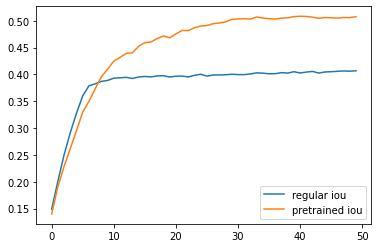

In [ ]:
plt.plot(epoch,regular_iou,label='regular iou')
plt.plot(epoch,pretrained_iou,label='pretrained iou')
plt.legend()
plt.show()

In [ ]:
regular_ef=x.iloc[:,1:2].values
pretrained_ef=y.iloc[:,1:2].values 

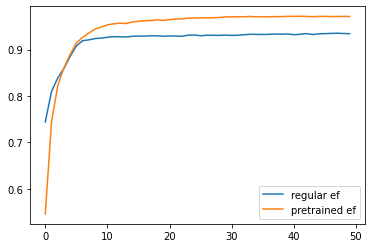

In [ ]:
plt.plot(epoch,regular_ef,label='regular ef')
plt.plot(epoch,pretrained_ef,label='pretrained ef')
plt.legend()
plt.show()